In [1]:
import os
import sys
import logging
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Dict, Any, List, Generator

In [2]:
# package imports
from vsim import electorate, candidates, simulation, voting_system

# Measuring fairness - Metric convergence

In [18]:
# setup helper for generating experiments (basically all sets of params to run through sim)
def generate_experiment_matrix(experiments: Dict[str, List[Any]]):
    return (dict(zip(experiments, x)) for x in itertools.product(*experiments.values()))


experiments = {
    "electorate_size": [10_000],
    "clusters": [10],
    "cluster_std": [1.5],
    "electoral_system": ["plurality", "majority", "approval"],
    "apathy_prob": [0.0],
    "candidates": [5],
    "issues": [2],
    "n_approvals_per_voter": [2]
}

records = []
columns = [*experiments.keys(), "unweighted_fairness", "weighted_fairness", "t"]
experiment_matrix = list(generate_experiment_matrix(experiments))

# montecarlo for given limited number of params (only chaning approva)
for t in tqdm(range(1, 10_000 + 1)):    
    for params in experiment_matrix:

        # setup objects
        voters = electorate.setup_electorate(**params)
        parties = candidates.setup_candidates(**params, electorate=voters)
        system = voting_system.setup_voting_system(name=params["electoral_system"], **params)

        # simulate elections
        sim = simulation.VotingSimulator(electorate=voters, candidates=parties, system=system, log=logging.getLogger())
        
        try:    
            result = sim.run()
            result_record = { 
                "t": t,
                "unweighted_fairness": round(result.unweighted_fairness, 3),
                "weighted_fairness": round(result.weighted_fairness, 3),
                **params,
            }
            records.append(result_record)
        except AssertionError as e:
            # parameter matrix generates configurations that are potentially not supported by all
            # voting systems; in that case we just forgo running that param set in particular.
            if e is AssertionError("more votes than candidates"):
                continue

100%|█████████████████████| 10000/10000 [42:48<00:00,  3.89it/s]


In [20]:
results_df = pd.DataFrame.from_records(records)
results_df.head()

,unweighted_fairness,weighted_fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,n_approvals_per_voter
0,0.858,0.739,10000,10,1.5,plurality,0.0,5,2,2
1,0.745,0.764,10000,10,1.5,majority,0.0,5,2,2
2,1.049,0.821,10000,10,1.5,approval,0.0,5,2,2
3,0.746,0.748,10000,10,1.5,plurality,0.0,5,2,2
4,0.538,0.605,10000,10,1.5,majority,0.0,5,2,2


In [52]:
# stoe away so we don't need to rerun experiment
filepath = "data/fairness-convergence-2ece7ca4-007f-42ed-9681-7f6e7c6e2084.csv"
assert not os.path.isfile(filepath), "data export already exists. Use a new uuid to prevent overwriting"
results_df.to_csv(filepath, index=False)

AssertionError: data export already exists. Use a new uuid to prevent overwriting

In [53]:
results_df

,unweighted_fairness,weighted_fairness,electorate_size,clusters,cluster_std,electoral_system,apathy_prob,candidates,issues,n_approvals_per_voter
0,0.858,0.739,10000,10,1.5,plurality,0.0,5,2,2
1,0.745,0.764,10000,10,1.5,majority,0.0,5,2,2
2,1.049,0.821,10000,10,1.5,approval,0.0,5,2,2
3,0.746,0.748,10000,10,1.5,plurality,0.0,5,2,2
4,0.538,0.605,10000,10,1.5,majority,0.0,5,2,2
...,...,...,...,...,...,...,...,...,...,...
29995,0.581,0.642,10000,10,1.5,majority,0.0,5,2,2
29996,0.947,0.877,10000,10,1.5,approval,0.0,5,2,2
29997,0.670,0.760,10000,10,1.5,plurality,0.0,5,2,2
29998,0.720,0.740,10000,10,1.5,majority,0.0,5,2,2


In [56]:
# calculate cumulative averages for each electoral system
majority = results_df.electoral_system == "majority"
plurality = results_df.electoral_system == "plurality"
approval = results_df.electoral_system == "approval"

In [57]:
majority_df = results_df[majority].reset_index().drop(["index"], axis=1).reset_index()
plurality_df = results_df[plurality].reset_index().drop(["index"], axis=1).reset_index()
approval_df = results_df[approval].reset_index().drop(["index"], axis=1).reset_index()

In [59]:
# setup convergence metrics
majority_fairness_convergence = majority_df.weighted_fairness.cumsum() / majority_df.index
plurality_fairness_convergence = plurality_df.weighted_fairness.cumsum() / majority_df.index
approval_fairness_convergence = approval_df.weighted_fairness.cumsum() / majority_df.index

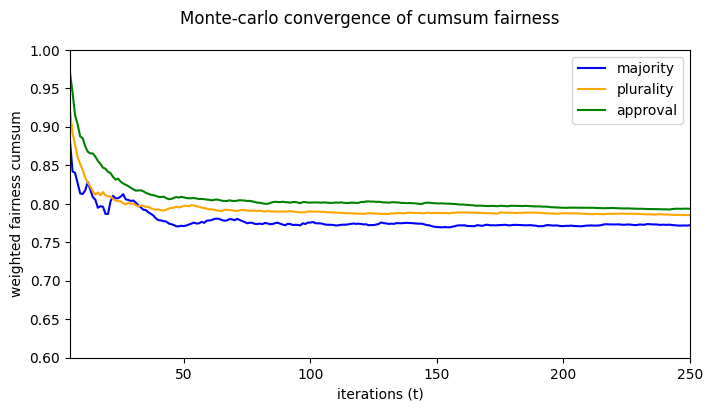

In [78]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
sns.lineplot(majority_fairness_convergence, color="blue", label="majority" , ax=ax)
sns.lineplot(plurality_fairness_convergence, color="orange", label="plurality", ax=ax)
sns.lineplot(approval_fairness_convergence, color="green", label="approval", ax=ax)
ax.set_xlim([5, 250]) # just for polish
ax.set_ylim([0.6, 1])
ax.set_xlabel("iterations (t)")
ax.set_ylabel("weighted fairness cumsum")
plt.suptitle("Monte-carlo convergence of cumsum fairness")
plt.show()